In [ ]:
https://drive.google.com/drive/folders/1EZBHhCCBc5Qs9Pydc3WJWhzQCRfc80s2?usp=drive_link

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import os

# Define the path to your dataset in Google Drive
dataset_path = "/content/drive/My Drive/New_Tomato_Dataset"

# List files in the dataset directory
files = os.listdir(dataset_path)

# Print the list of files
print(files)

['test', 'train', 'valid']


In [15]:
!pip install -q keras

In [16]:
import keras

Epoch 1/5
16/16 [==============================] - 14s 656ms/step - loss: 2.7427 - accuracy: 0.0980 - val_loss: 2.3746 - val_accuracy: 0.1200
Epoch 2/5
16/16 [==============================] - 10s 664ms/step - loss: 2.3536 - accuracy: 0.1080 - val_loss: 2.3561 - val_accuracy: 0.1200
Epoch 3/5
16/16 [==============================] - 9s 558ms/step - loss: 2.3110 - accuracy: 0.0980 - val_loss: 2.3484 - val_accuracy: 0.1240
Epoch 4/5
16/16 [==============================] - 9s 538ms/step - loss: 2.3063 - accuracy: 0.0720 - val_loss: 2.3460 - val_accuracy: 0.1260
Epoch 5/5
2/2 [==============================] - 1s 16ms/step - loss: 23.5621 - accuracy: 0.0000e+00
Test Loss: 23.5621
Test Accuracy: 0.00%
1/1 [==============================] - 1s 745ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


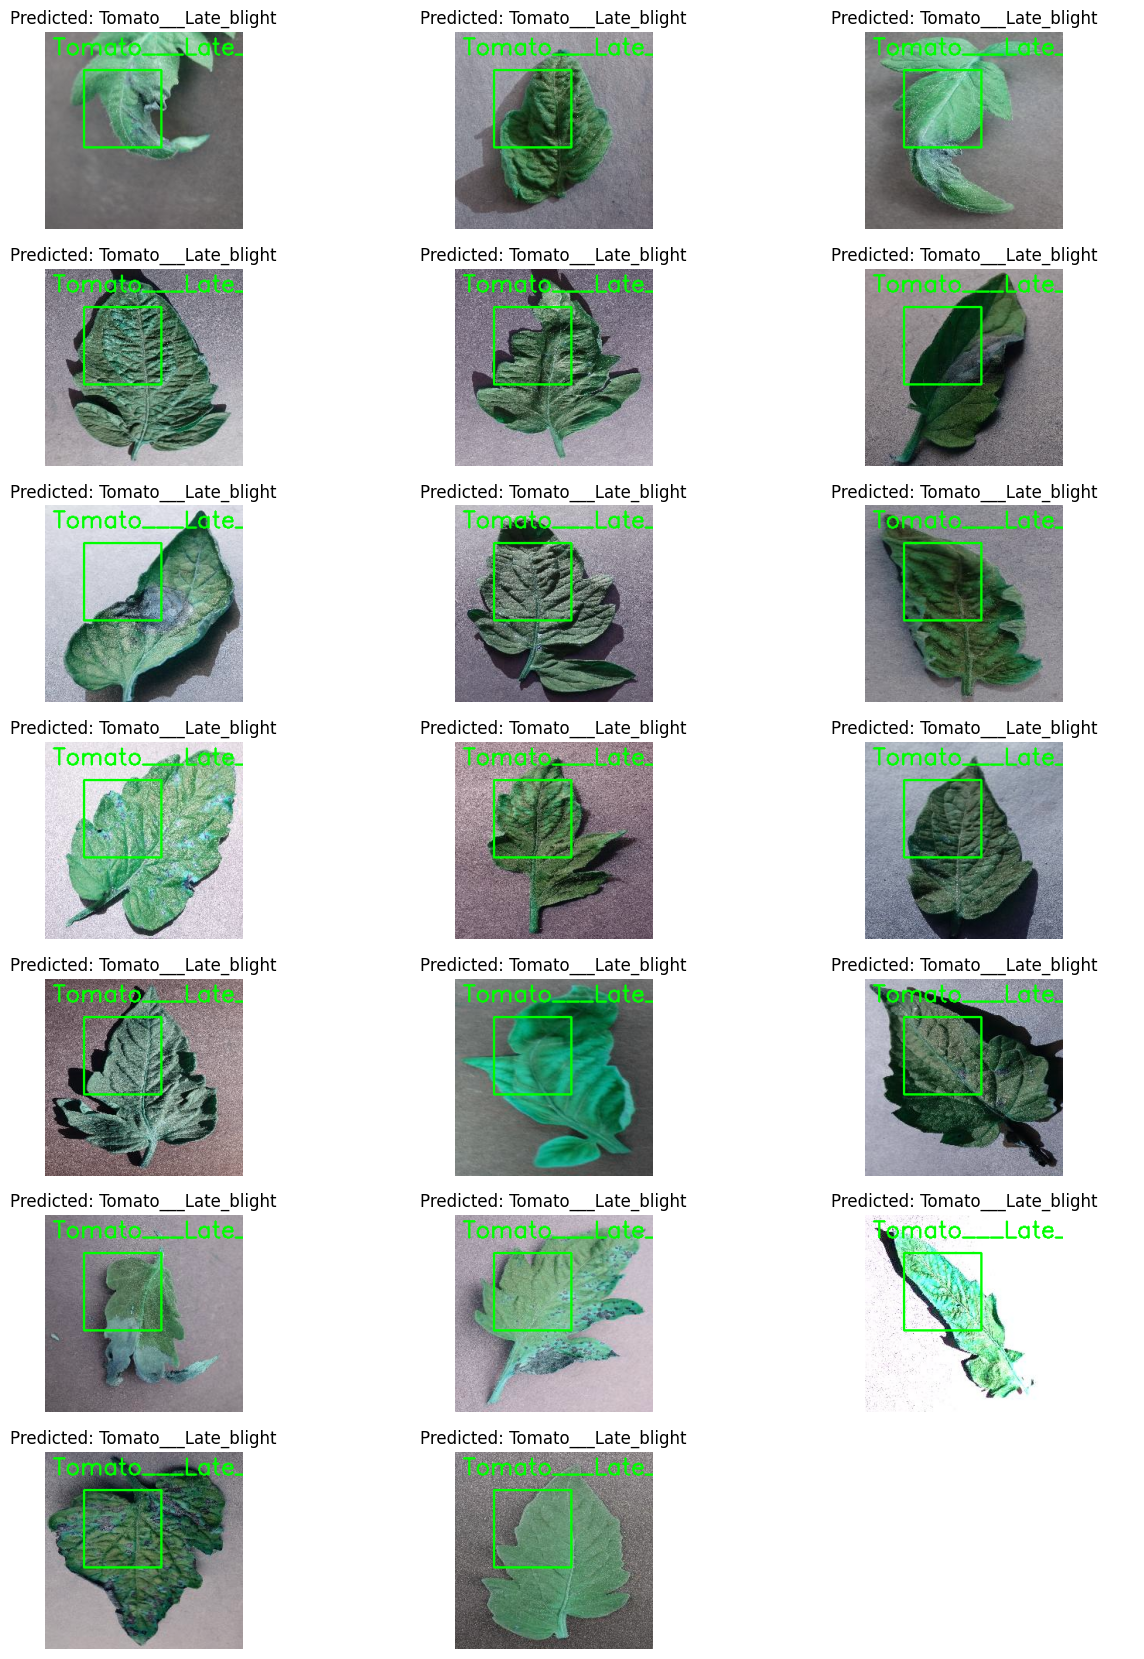

In [17]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define a function to load and preprocess images
def load_and_preprocess_data(directory, target_size=(256, 256), class_mode='categorical'):
    images = []
    labels = []

    label_encoder = LabelEncoder()  # Create a label encoder

    # Iterate through each class sub-directory
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)

        # Ignore non-directory files
        if not os.path.isdir(class_path):
            continue

        # Iterate through images in the class sub-directory
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)

            # Read and resize the image
            img = cv2.imread(img_path)
            img = cv2.resize(img, target_size)

            # Perform any additional preprocessing steps here (e.g., normalization)
            img = img / 255.0  # Normalization

            # Append the image and label to the lists
            images.append(img)
            labels.append(class_name)

    # Convert lists to numpy arrays
    images = np.array(images)

    # Encode class names to numerical labels
    labels = label_encoder.fit_transform(labels)

    # Convert labels to one-hot encoding
    labels = to_categorical(labels)

    # Shuffle the data
    images, labels = shuffle(images, labels, random_state=42)

    # Get the class names from the label encoder
    class_names = label_encoder.classes_

    return images, labels, class_names

# Load and preprocess training data
train_directory = '/content/drive/MyDrive/New_Tomato_Dataset/train'
validation_directory = '/content/drive/MyDrive/New_Tomato_Dataset/valid'
test_directory = '/content/drive/MyDrive/New_Tomato_Dataset/test'  # Add your test directory

train_images, train_labels, class_names = load_and_preprocess_data(train_directory, target_size=(256, 256))
validation_images, validation_labels, _ = load_and_preprocess_data(validation_directory, target_size=(256, 256))
test_images, test_labels, _ = load_and_preprocess_data(test_directory, target_size=(256, 256))  # Load and preprocess test data

# Create an ImageDataGenerator for augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255,
    fill_mode='nearest'
)

# Fit the ImageDataGenerator on the training data
train_datagen.fit(train_images)

# Load MobileNetV2 model without top layers
base_model = MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights='imagenet')

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for classification
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model (you may need more epochs and a larger dataset for better results)
history = model.fit(train_datagen.flow(train_images, train_labels, batch_size=32), epochs=5, validation_data=(validation_images, validation_labels))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Display images with bounding boxes on the validation set
def display_images_with_bounding_boxes(model, images, class_names, target_size=(256, 256), num_columns=3, max_images=5):
    num_images = min(len(images), max_images)
    num_rows = (num_images // num_columns) + (1 if num_images % num_columns > 0 else 0)

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 3 * num_rows))

    for i in range(num_rows):
        for j in range(num_columns):
            index = i * num_columns + j
            if index < num_images:
                img = images[index]
                img_array = np.expand_dims(cv2.resize(img, target_size), axis=0) / 255.0

                # Predict using the model
                predictions = model.predict(img_array)
                predicted_class = np.argmax(predictions[0])
                predicted_label = class_names[predicted_class]

                # Draw bounding box on the original image
                original_img = cv2.resize(img, target_size)
                original_img_with_box = original_img.copy()

                # Get the predicted bounding box coordinates (dummy values for illustration)
                x, y, w, h = 50, 50, 100, 100

                # Draw the bounding box
                cv2.rectangle(original_img_with_box, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.putText(original_img_with_box, predicted_label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

                # Display the image with bounding box
                axes[i, j].imshow(original_img_with_box)
                axes[i, j].set_title(f"Predicted: {predicted_label}")
                axes[i, j].axis('off')
            else:
                axes[i, j].axis('off')

    plt.show()

# Display a limited number of images with bounding boxes on the validation set
display_images_with_bounding_boxes(model, validation_images, class_names, num_columns=3, max_images=20)
